In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data

In [2]:
#获取行业分类
industrys = DP.get_all_industrys()

In [182]:
industry = ['801740.SI']

#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])

money_dic = get_stock_money_data(industrys, industry)

In [183]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

/Users/yiqingsheng/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [184]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [185]:
n = 2
y = standardize_industry(ror.rolling(n).sum().shift(-n+1) - r_geye, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [186]:
x1 = standardize(r_rinei)
x2 = standardize(r_rinei.rolling(1).mean().shift(1))
x3 = standardize(r_rinei.rolling(3).mean().shift(2))
x4 = standardize(r_rinei.rolling(5).mean().shift(5))
x5 = standardize(r_rinei.rolling(10).mean().shift(10))

z1 = standardize(r_geye)
z2 = standardize(r_geye.rolling(1).mean().shift(1))
z3 = standardize(r_geye.rolling(3).mean().shift(2))
z4 = standardize(r_geye.rolling(5).mean().shift(5))
z5 = standardize(r_geye.rolling(10).mean().shift(10))

u1 = x1 - z1
u2 = x2 - z2
u3 = x3 - z3
u4 = x4 - z4
u5 = x5 - z5

r1 = x1 + z1
r2 = x2 + z2
r3 = x3 + z3
r4 = x4 + z4
r5 = x5 + z5

h1 = standardize(rh)
h2 = standardize(rh).rolling(1).mean().shift(1)
h3 = standardize(rh).rolling(3).mean().shift(2)
h4 = standardize(rh).rolling(5).mean().shift(5)
h5 = standardize(rh).rolling(10).mean().shift(10)

l1 = standardize(rl)
l2 = standardize(rl).rolling(1).mean().shift(1)
l3 = standardize(rl).rolling(3).mean().shift(2)
l4 = standardize(rl).rolling(5).mean().shift(5)
l5 = standardize(rl).rolling(10).mean().shift(10)

hl1 = h1 - l1
hl2 = h2 - l2
hl3 = h3 - l3
hl4 = h4 - l4
hl5 = h5 - l5

ch1 = x1 - h1
ch2 = x2 - h2
ch3 = x3 - h3
ch4 = x4 - h4
ch5 = x5 - h5

cl1 = x1 - l1
cl2 = x2 - l2
cl3 = x3 - l3
cl4 = x4 - l4
cl5 = x5 - l5


vr1 = standardize(vr)
vr2 = standardize(vr).rolling(1).mean().shift(1)
vr3 = standardize(vr).rolling(3).mean().shift(2)
vr4 = standardize(vr).rolling(5).mean().shift(5)
vr5 = standardize(vr).rolling(10).mean().shift(10)


rzrq1 = standardize(d_rzrq).fillna(0)
rzrq2 = standardize(d_rzrq.rolling(1).mean().shift(1)).fillna(0)
rzrq3 = standardize(d_rzrq.rolling(3).mean().shift(2)).fillna(0)
rzrq4 = standardize(d_rzrq.rolling(5).mean().shift(5)).fillna(0)
rzrq5 = standardize(d_rzrq.rolling(10).mean().shift(10)).fillna(0)

gt1 = standardize(d_gt).fillna(0)
gt2 = standardize(d_gt.rolling(1).mean().shift(1)).fillna(0)
gt3 = standardize(d_gt.rolling(3).mean().shift(2)).fillna(0)
gt4 = standardize(d_gt.rolling(5).mean().shift(5)).fillna(0)
gt5 = standardize(d_gt.rolling(10).mean().shift(10)).fillna(0)

pe = standardize(pe)
pb = standardize(pb)
ps = standardize(ps)

lmv = standardize(lmv)


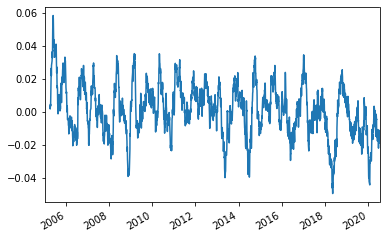

In [187]:
(l4.shift()*y).mean(1).fillna(0).rolling(60).mean().plot()

In [188]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5,#没啥用
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,#多余
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,#估计没ch好用
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,#同下
    'ch1':ch1, 'ch2':ch2, 'ch3':ch3, 'ch4':ch4, 'ch5':ch5,#试试看
    'cl1':cl1, 'cl2':cl2, 'cl3':cl3, 'cl4':cl4, 'cl5':cl5,#试试看
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,#逻辑不好
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps,
    'lmv':lmv,
}

In [189]:
begin_date = '2010-01-01'
split_date = '2016-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [190]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [191]:
#df_train.corr().iloc[0,:].sort_values()

In [204]:
model = smf.ols('y~x1+x2+x3\
                  +z1+z2+z3\
                  +ch1+ch2+ch3\
                  +cl1+cl2+cl3\
                  \
                  \
                  \
                  +pe\
                  +lmv', data=df_train).fit()
model.tvalues

Intercept    -0.888207
x1           -4.801659
x2           -4.516965
x3           -2.797999
z1            0.107641
z2           -2.268928
z3           -5.279191
ch1          -4.169765
ch2          -4.360491
ch3          -1.935933
cl1           3.595368
cl2           0.048698
cl3          -1.394100
pe            4.777521
lmv         -10.660735
dtype: float64

300810.SZ    0.129474
300719.SZ    0.124647
300722.SZ    0.096368
600391.SH    0.094744
600316.SH    0.094664
300456.SZ    0.094537
601606.SH    0.093946
300527.SZ    0.089947
300474.SZ    0.085866
300101.SZ    0.074698
Name: 2020-07-17 00:00:00, dtype: float64


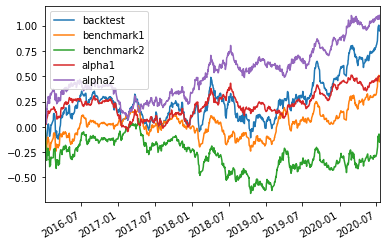

In [210]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q = 1 - 2.5 / len(y_hat.columns)
position = (y_hat.gt(y_hat.quantile(q, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [211]:
position.sum(1)

2016-01-04    0
2016-01-05    2
2016-01-06    2
2016-01-07    2
2016-01-08    2
             ..
2020-07-13    3
2020-07-14    3
2020-07-15    3
2020-07-16    3
2020-07-17    3
Length: 1105, dtype: int64

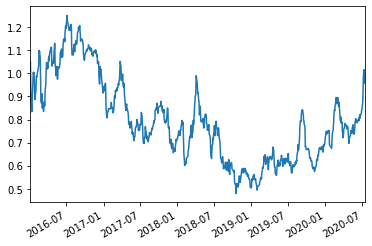

In [212]:
(ror_huice.mean(1)-0.0007+1).cumprod().plot()

In [213]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300474.SZ    0.159359
300719.SZ    0.116622
300600.SZ    0.116584
002190.SZ    0.110702
300722.SZ    0.093044
300101.SZ    0.082079
601890.SH    0.074429
300456.SZ    0.070905
300810.SZ    0.068170
601606.SH    0.057804
Name: 2020-07-17 00:00:00, dtype: float64


In [465]:
df_train = df_train.dropna()
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

array([0.05159753, 0.05007378, 0.04443164, 0.04619165, 0.04480049,
       0.04128151, 0.04127881, 0.05454827, 0.05270984, 0.05264996,
       0.04963717, 0.05406033, 0.04655707, 0.04854932, 0.0502602 ,
       0.0494474 , 0.04531465, 0.04479211, 0.04590302, 0.0421521 ,
       0.04376315])